In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
from kaggle_util import *
from models import *

t_start = time.time()

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Build model
def build_vgg_unet_model(input_shape, DropoutRatio = 0.5, weights = 'imagenet'):
    input_layer = Input(input_shape)
    
    # block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(input_layer)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2), strides=(2,2))(conv1)

    # block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2), strides=(2,2))(conv2)
    
    # block3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2), strides=(2,2))(conv3)
    
    # block4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2), strides=(2,2))(conv4)
    
    # block5
    conv5 = Conv2D(512, (3, 3), activation='relu', padding="same")(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv5)
    pool5 = MaxPooling2D((2, 2), strides=(2,2))(conv5)
    
    # Middle
    if DropoutRatio > 0:
        pool5 = Dropout(DropoutRatio)(pool5)
    convm = Conv2D(1024, (3, 3), activation="relu", padding="same")(pool5)
    
    # uconv5
    deconv5 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv5 = concatenate([deconv5, conv5])
    if DropoutRatio > 0:
        uconv5 = Dropout(DropoutRatio)(uconv5)
    uconv5 = Conv2D(512, (3, 3), activation="relu", padding="same")(uconv5)
#     uconv5 = residual_block(uconv5,512)
    uconv5 = residual_block(uconv5,512, True)
    
    # uconv4
    deconv4 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(uconv5)
    uconv4 = concatenate([deconv4, conv4])
    if DropoutRatio > 0:
        uconv4 = Dropout(DropoutRatio)(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(uconv4)
#     uconv4 = residual_block(uconv4,512)
    uconv4 = residual_block(uconv4,512, True)
    
    # uconv3
    deconv3 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    if DropoutRatio > 0:
        uconv3 = Dropout(DropoutRatio)(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(uconv3)
#     uconv3 = residual_block(uconv3,256)
    uconv3 = residual_block(uconv3,256, True)
    
    # uconv2
    deconv2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    if DropoutRatio > 0:
        uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(uconv2)
#     uconv2 = residual_block(uconv2,128)
    uconv2 = residual_block(uconv2,128, True)
    
    # uconv1
    deconv1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    if DropoutRatio > 0:
        uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(uconv1)
#     uconv1 = residual_block(uconv1,64)
    uconv1 = residual_block(uconv1,64, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    model = Model(input_layer, output_layer)
    
    if weights == 'imagenet':
        vgg = VGG16(input_shape = input_shape, include_top = False, weights = 'imagenet')
        for i in range(1, len(vgg.layers)):
            model.layers[i].set_weights(vgg.layers[i].get_weights())
            model.layers[i].trainable = False
            
    return model



In [3]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=False)) for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [4]:
SUBSET = len(train_df)
train_df = train_df.head(SUBSET)
len(train_df)

4000

In [5]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
train_df.index.values,
np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3), 
np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
train_df.coverage.values,
train_df.z.values,
test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [6]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 128, 128, 3)
(800, 128, 128, 1)


In [7]:
batch_size = 32
dropout = 0.5
base_name = 'Unet_vgg_{}_{}'.format(batch_size, dropout)
basic_name = '../model/{}'.format(base_name)
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

# model
model1 = build_vgg_unet_model((img_size_target, img_size_target, 3), 
                              DropoutRatio = dropout, weights = 'imagenet')

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

board = keras.callbacks.TensorBoard(log_dir='log/{}'.format(base_name),
                       histogram_freq=0, write_graph=True, write_images=False)
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=3, min_lr=0.00001, verbose=1)

epochs = 200

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, early_stopping, model_checkpoint,reduce_lr], 
                    verbose=1)

from keras import backend as K
K.clear_session()

../model/Unet_vgg_32_0.5.model
../model/Unet_vgg_32_0.5.csv
Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 77s 12ms/step - loss: 0.3006 - my_iou_metric: 0.3739 - val_loss: 0.2306 - val_my_iou_metric: 0.4973

Epoch 00001: val_my_iou_metric improved from -inf to 0.49725, saving model to ../model/Unet_vgg_32_0.5.model
Epoch 2/200
6400/6400 [==============================] - 71s 11ms/step - loss: 0.2007 - my_iou_metric: 0.5526 - val_loss: 0.1931 - val_my_iou_metric: 0.6221

Epoch 00002: val_my_iou_metric improved from 0.49725 to 0.62213, saving model to ../model/Unet_vgg_32_0.5.model
Epoch 3/200
6400/6400 [==============================] - 71s 11ms/step - loss: 0.1775 - my_iou_metric: 0.6141 - val_loss: 0.1811 - val_my_iou_metric: 0.6686

Epoch 00003: val_my_iou_metric improved from 0.62213 to 0.66862, saving model to ../model/Unet_vgg_32_0.5.model
Epoch 4/200
6400/6400 [==============================] - 71s 11ms/step - loss: 0.1573 

In [8]:
model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})

base_name = 'Unet_vgg_stage2_{}_{}'.format(batch_size, dropout)
basic_name = '../model/{}'.format(base_name)
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.00001, verbose=1)
epochs = 200

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, model_checkpoint,reduce_lr,early_stopping], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 126s 20ms/step - loss: -0.3402 - my_iou_metric_2: 0.7897 - val_loss: 0.3951 - val_my_iou_metric_2: 0.6824

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.68237, saving model to ../model/Unet_vgg_stage2_32_0.5.model
Epoch 2/200
6400/6400 [==============================] - 122s 19ms/step - loss: -0.3731 - my_iou_metric_2: 0.7878 - val_loss: 0.2444 - val_my_iou_metric_2: 0.6849

Epoch 00002: val_my_iou_metric_2 improved from 0.68237 to 0.68488, saving model to ../model/Unet_vgg_stage2_32_0.5.model
Epoch 3/200
6400/6400 [==============================] - 122s 19ms/step - loss: -0.4258 - my_iou_metric_2: 0.7962 - val_loss: 0.4260 - val_my_iou_metric_2: 0.6808

Epoch 00003: val_my_iou_metric_2 did not improve from 0.68488
Epoch 4/200
6400/6400 [==============================] - 122s 19ms/step - loss: -0.4391 - my_iou_metric_2: 0.7959 - val_loss: 0.3513 - val_my_iou_metric_2: 0.68

6400/6400 [==============================] - 122s 19ms/step - loss: -0.7523 - my_iou_metric_2: 0.8443 - val_loss: 0.5434 - val_my_iou_metric_2: 0.6950

Epoch 00034: val_my_iou_metric_2 did not improve from 0.69938
Epoch 35/200
6400/6400 [==============================] - 122s 19ms/step - loss: -0.7560 - my_iou_metric_2: 0.8449 - val_loss: 0.5782 - val_my_iou_metric_2: 0.6972

Epoch 00035: val_my_iou_metric_2 did not improve from 0.69938
Epoch 36/200
6400/6400 [==============================] - 122s 19ms/step - loss: -0.7645 - my_iou_metric_2: 0.8454 - val_loss: 0.5989 - val_my_iou_metric_2: 0.6972

Epoch 00036: val_my_iou_metric_2 did not improve from 0.69938
Epoch 37/200
6400/6400 [==============================] - 122s 19ms/step - loss: -0.7612 - my_iou_metric_2: 0.8455 - val_loss: 0.5953 - val_my_iou_metric_2: 0.6974

Epoch 00037: val_my_iou_metric_2 did not improve from 0.69938

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 38/200
6400/6400 [

In [9]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})




[0.728875 0.728375 0.7275   0.72725  0.727    0.726625 0.726125 0.725375
 0.725125 0.724625 0.7245   0.7245   0.724    0.723375 0.723375 0.72225
 0.721625 0.721125 0.720875 0.72025  0.720875 0.721375 0.719875 0.71975
 0.719125 0.71825  0.71775  0.718125 0.718    0.716375 0.716625]


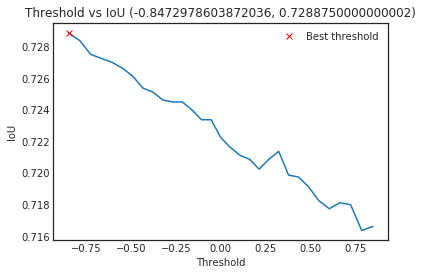

In [10]:
preds_valid = predict_result(model,x_valid,img_size_target)
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [11]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 3)

preds_test = predict_result(model,x_test,img_size_target)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


ValueError: cannot reshape array of size 183618000 into shape (128,128,3)

In [ ]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub = sub.reset_index()
save_result(sub, '../result/{}.csv'.format(base_name), 
                        competition = 'tgs-salt-identification-challenge', 
                        send = True, index = False)

t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")